In [1]:
from pathlib import Path 
import os 

In [3]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def read_data(file_paths):
    """
    Read data from multiple files and concatenate durations.
    
    Args:
        file_paths: List of file paths to read data from
        
    Returns:
        durations: Concatenated array of duration values
    """
    all_durations = []
    
    for file_path in file_paths:
        data = pd.read_csv(file_path, sep='\t', header=None, names=['timestamps', 'durations'])
        all_durations.append(data['durations'].values)
    
    return np.concatenate(all_durations)

def generate_bin(durations, interval):
    """
    Bin durations into intervals and calculate density.
    
    Args:
        durations: List of duration values
        interval: Size of each bin
        
    Returns:
        bin_centers: Centers of each bin
        bin_density: Density count in each bin
    """
    max_duration = np.max(durations)
    num_bins = int(np.ceil(max_duration / interval))
    bins = np.linspace(0, num_bins * interval, num_bins + 1)
    
    hist, bin_edges = np.histogram(durations, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_density = hist / (len(durations) * interval)
    
    return bin_centers, bin_density

def kde_traces(durations, interval, name=None):
    """
    Generate histogram and density estimate traces.
    
    Args:
        durations: List of duration values
        interval: Size of each bin
        name: Legend group name (defaults to interval+μs if None)
    
    Returns:
        List of plotly traces for histogram and density
    """
    bin_centers, bin_density = generate_bin(durations, interval)
    
    # Set default legend group name if not provided
    if name is None:
        name = f"{interval}μs"
    
    # Generate a consistent color for both traces
    color = f"hsl({hash(name) % 360}, 70%, 50%)"
    
    # Create histogram trace
    histogram_trace = go.Histogram(
        x=durations,
        xbins=dict(
            start=0,
            end=np.max(durations),
            size=interval
        ),
        histnorm='probability density',
        name=f"{name} histogram",
        legendgroup=name,
        opacity=0.7,
        marker_color=color
    )
    
    # Create density trace
    density_trace = go.Scatter(
        x=bin_centers,
        y=bin_density,
        mode='markers+lines',
        name=f"{name} density",
        legendgroup=name,
        marker=dict(size=8, color=color),
        line=dict(color=color)
    )
    
    return [density_trace]

data_files = [Path('../raw_data/m_0306_0.txt'), Path('../raw_data/m_0306_1.txt')]
durations = read_data(data_files)

traces = []
for i in [0.05, 0.1, 0.2, 0.5, 1]: 
    traces.extend(kde_traces(durations, i))

fig = go.Figure(data=traces)
fig.show()

In [113]:
def kde_sample(durations, kde_num_samples, normalized=True):
    """
    Create a KDE sample with equally spaced points.
    
    Parameters:
    -----------
    durations : array-like
        The data points to analyze
    kde_num_samples : int
        Number of equally spaced sample points to generate
    normalized : bool, default=True
        If True, normalize the bin counts so that the sum of bin_width * bin_density[j] equals 1
    
    Returns:
    --------
    bin_centers : array
        The centers of each bin (equally spaced points)
    bin_counts : array
        The count/density at each bin center
    """
    min_val = np.min(durations)
    max_val = np.max(durations)
    
    # Calculate interval width to get kde_num_samples points
    interval_width = (max_val - min_val) / (kde_num_samples - 1)
    
    # Create equally spaced points
    bin_centers = np.linspace(min_val, max_val, kde_num_samples)
    
    # Create bin edges (bin_centers are the LHS of bins)
    bin_edges = np.append(bin_centers, bin_centers[-1] + interval_width)
    
    # Count occurrences in each bin
    bin_counts, _ = np.histogram(durations, bins=bin_edges, density=False)
    
    # Convert counts to density
    bin_counts = bin_counts / (len(durations) * interval_width)
    
    # Normalize if requested
    if normalized:
        # Ensure the sum of bin_width * bin_density equals 1
        normalization_factor = np.sum(bin_counts * interval_width)
        if normalization_factor > 0:  # Avoid division by zero
            bin_counts = bin_counts / normalization_factor
    
    return bin_centers, bin_counts

def conditional_exponential(tau, lower_threshold, upper_threshold, num_samples):
    """
    Generate a conditional exponential distribution with lifetime tau, 
    conditioned on the result being between lower_threshold and upper_threshold.
    
    Parameters:
    -----------
    tau : float
        The lifetime parameter of the exponential distribution
    lower_threshold : float
        The lower bound of the conditioning interval
    upper_threshold : float
        The upper bound of the conditioning interval
    num_samples : int
        Number of equally spaced sample points to generate
    
    Returns:
    --------
    bin_centers : array
        The centers of each bin (equally spaced points)
    exp_density : array
        The density values at each bin center, normalized so that 
        bin_width * sum(exp_density) = 1
    """
    # Create equally spaced points between the thresholds - using the same approach as kde_sample
    bin_centers = np.linspace(lower_threshold, upper_threshold, num_samples)
    bin_width = (upper_threshold - lower_threshold) / (num_samples - 1)
    
    # Calculate the unnormalized exponential density at each point
    exp_density = (1/tau) * np.exp(-bin_centers/tau)
    
    # Calculate the normalization factor for the conditional distribution
    # For an exponential distribution, the probability in the interval [a,b] is:
    # P(a ≤ X ≤ b) = exp(-a/tau) - exp(-b/tau)
    normalization_factor = np.exp(-lower_threshold/tau) - np.exp(-upper_threshold/tau)
    
    # Normalize the density values
    exp_density = exp_density / normalization_factor
    
    # Ensure that bin_width * sum(exp_density) = 1
    current_sum = bin_width * np.sum(exp_density)
    exp_density = exp_density / current_sum
    
    return bin_centers, exp_density

def subtract_uniform(density, support_min, support_max, uniform_mixup=0):
    """
    Subtract a uniform component from a density and renormalize.
    
    Parameters:
    -----------
    density : array-like
        The density values to process
    support_min : float
        The minimum value of the support
    support_max : float
        The maximum value of the support
    uniform_mixup : float, default=0
        Fraction of uniform distribution mixed with the density (between 0 and 1)
    
    Returns:
    --------
    array
        The processed density with uniform component removed and renormalized
    """
    # Create uniform density with the same support
    uniform_density = np.ones_like(density) / (support_max - support_min)
    bin_width = (support_max - support_min) / (len(density) - 1)
    
    # Solve for the "true" underlying density, assuming density is the mixed density
    # density = uniform_mixup * uniform_density + (1 - uniform_mixup) * underlying_density
    # Therefore: underlying_density = (density - uniform_mixup * uniform_density) / (1 - uniform_mixup)
    underlying_density = (density - uniform_mixup * uniform_density) / (1 - uniform_mixup)
    
    # Ensure all values are non-negative
    underlying_density = np.maximum(underlying_density, 1e-5)
    
    # Renormalize to ensure it integrates to 1
    normalization_factor = np.sum(underlying_density * bin_width)
    if normalization_factor > 0:  # Avoid division by zero
        underlying_density = underlying_density / normalization_factor
    
    return underlying_density

def kldiv(durations, lower_quantile, upper_quantile, lifetime, uniform_mixup=0, num_samples=1000):
    """
    Calculate the KL divergence between the empirical distribution of durations
    and a conditional exponential distribution with the given parameters.
    
    Parameters:
    -----------
    durations : array-like
        The empirical duration data
    lower_quantile : float
        The lower quantile (between 0 and 1) for thresholding
    upper_quantile : float
        The upper quantile (between 0 and 1) for thresholding
    lifetime : float
        The lifetime parameter of the exponential distribution
    uniform_mixup : float, optional
        Fraction of uniform distribution mixed with exponential (between 0 and 1)
    num_samples : int, optional
        Number of equally spaced sample points to generate (default: 1000)
    
    Returns:
    --------
    float
        The KL divergence between the empirical and model distributions
    """
    # Convert quantiles to actual threshold values
    lower_threshold = np.quantile(durations, lower_quantile)
    upper_threshold = np.quantile(durations, upper_quantile)
    
    # Filter durations to only include those within the thresholds
    filtered_durations = durations[(durations >= lower_threshold) & (durations <= upper_threshold)]
    
    ce_center, ce_density = conditional_exponential(
        lifetime, lower_threshold, upper_threshold, num_samples)
    emp_center, emp_density = kde_sample(filtered_durations, num_samples, normalized=True)

    # Subtract uniform component and renormalize
    underlying_density = subtract_uniform(emp_density, lower_threshold, upper_threshold, uniform_mixup)
    
    # Calculate KL divergence
    bin_width = ce_center[1] - ce_center[0]
    kldiv = np.nan_to_num(np.sum(underlying_density * bin_width * np.log(underlying_density / ce_density)), nan=1e10)
    return kldiv

# Define objective function for the optimizer
def objective(params, durations):
    lifetime, lower_quantile, upper_quantile, uniform_mixup, num_samples = params
    return kldiv(durations, lower_quantile, upper_quantile, lifetime, uniform_mixup, num_samples=int(num_samples))

In [114]:
# Import optimization function
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

bounds = [
    (0.1, 10),                  # lifetime bounds
    (0.0, 0.6),    # lower threshold bounds: min to 0.5 quantile
    (0.8, 1.0),    # upper threshold bounds: 0.5 quantile to max
    (1e-5, 0.1),                      # uniform_mixup bounds: between 0 and 1
    (100, 1001)                      # num_samples bounds: between 100 and 1000
]

# Define a callback function to track optimization progress
optimization_history = []
def callback_func(xk, convergence):
    # Calculate current objective value
    current_value = objective(xk, durations)
    optimization_history.append(current_value)
    return False

# Set fixed number of iterations
max_iterations = 1000

# Run optimization with fixed number of iterations
result = differential_evolution(
    objective, 
    bounds, 
    args=(durations,), 
    workers=1,  # Use all available CPU cores
    updating='deferred',  # Required for parallel processing
    disp=True,  # Display progress
    maxiter=max_iterations,
    callback=callback_func
)

# Plot the optimization progress
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(optimization_history) + 1), optimization_history)
plt.xlabel('Iteration')
plt.ylabel('KL Divergence')
plt.title('Optimization Progress')
plt.grid(True)
plt.show()

print(f"Optimization completed after {len(optimization_history)} iterations")
print(f"Final KL divergence: {optimization_history[-1] if optimization_history else 'N/A'}")

differential_evolution step 1: f(x)= 0.008942055820074901
differential_evolution step 2: f(x)= 0.008942055820074901


KeyboardInterrupt: 

In [102]:
# Extract the best parameters and score
best_lifetime, best_lower, best_upper, best_uniform_mixup, best_num_samples = result.x
best_score = result.fun

print(f"Best parameters:")
print(f"  Lifetime: {best_lifetime}")
print(f"  Lower threshold: {best_lower}")
print(f"  Upper threshold: {best_upper}")
print(f"  Uniform mixup: {best_uniform_mixup}")
print(f"  Number of samples: {int(best_num_samples)}")
print(f"Best KL divergence: {best_score}")

# Calculate KL divergence with the best parameters
kldiv_value = kldiv(durations, best_lower, best_upper, best_lifetime, best_uniform_mixup)

Best parameters:
  Lifetime: 3.5629618204174616
  Lower threshold: 0.48685249835509214
  Upper threshold: 0.8005210870994252
  Uniform mixup: 1e-05
  Number of samples: 130
Best KL divergence: 0.005575524565756055


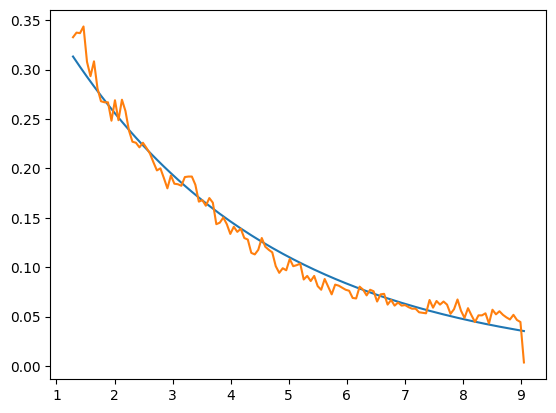

In [117]:
lower_threshold = np.quantile(durations, best_lower)
upper_threshold = np.quantile(durations, best_upper)
best_num_samples = int(best_num_samples)
filtered_durations = durations[(durations >= lower_threshold) & (durations <= upper_threshold)]

ce_center, ce_density = conditional_exponential(
    best_lifetime, lower_threshold, upper_threshold, best_num_samples)
emp_center, emp_density = kde_sample(filtered_durations, best_num_samples, normalized=True)

uniform_density = np.ones_like(ce_density) / (upper_threshold - lower_threshold)

# Solve for the "true" underlying density, assuming emp_density is the mixed density
# emp_density = uniform_mixup * uniform_density + (1 - uniform_mixup) * underlying_density
# Therefore: underlying_density = (emp_density - uniform_mixup * uniform_density) / (1 - uniform_mixup)
underlying_density = (emp_density - best_uniform_mixup * uniform_density) / (1 - best_uniform_mixup)

plt.plot(ce_center, ce_density)
plt.plot(emp_center, underlying_density)
plt.show()


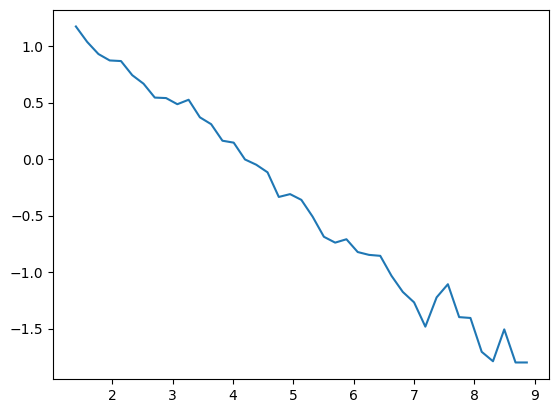

In [126]:
emp_center, emp_density = kde_sample(durations, best_num_samples, normalized=True)
emp_density = subtract_uniform(emp_density, emp_density.min(), emp_density.max(), 0.01)
mask = (emp_center > lower_threshold) & (emp_center < upper_threshold)
plt.plot(emp_center[mask], np.log(emp_density[mask]))

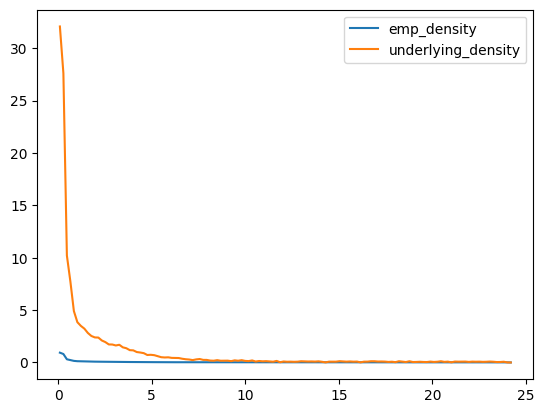

In [131]:
emp_center, emp_density = kde_sample(durations, best_num_samples, normalized=True)
underlying_density = subtract_uniform(emp_density, emp_density.min(), emp_density.max(), 0.01)
plt.plot(emp_center, emp_density, label='emp_density')
plt.plot(emp_center, underlying_density, label='underlying_density')
plt.legend()
plt.show()

In [132]:
emp_density.sum(), underlying_density.sum()

(5.353141339530251, 137.71151987921493)